In [206]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
import json
from environment import Environment
from logging_config import setup_logging
import logging
from utils import findUE, BPRCostFunction, findSO   
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])
pd.options.mode.chained_assignment = None  # default='warn'

In [239]:
import pandas as pd
import random
import numpy as np

In [ ]:
params = None
with open("params.json") as f:
    params = json.load(f)
params
env1 = Environment(params) #1st Area
params['env_params']['PoA'] = 1.3
env2 = Environment(params) #1st Area
envs = [env1,env2]

[ENV 1] routes=3, Q_env=323, Is=0.20, q_env=0.775, tUE=1.227, tSO=[0.9126303208612908, 1.2875875179244074, 0.9726185105599656], mean_SO_time=1.058, mean_inequity=0.145
[ENV 2] routes=3, Q_env=327, Is=0.40, q_env=0.785, tUE=1.862, tSO=[1.8847675614354449, 0.802668046027037, 1.0573688794579519], mean_SO_time=1.248, mean_inequity=0.204
[ENV 1] routes=3, Q_env=349, Is=0.11, q_env=0.838, tUE=1.259, tSO=[0.9590320972558319, 1.3340760781167824, 1.0191331050537915], mean_SO_time=1.104, mean_inequity=0.068
[ENV 2] routes=3, Q_env=341, Is=0.32, q_env=0.818, tUE=1.862, tSO=[1.9008305842860291, 0.8187534841176233, 1.0734717494528183], mean_SO_time=1.264, mean_inequity=0.165
[ENV 1] routes=3, Q_env=329, Is=0.18, q_env=0.790, tUE=1.234, tSO=[0.9223314472104721, 1.297311492931589, 0.9823486428143471], mean_SO_time=1.067, mean_inequity=0.127
[ENV 2] routes=3, Q_env=328, Is=0.40, q_env=0.787, tUE=1.862, tSO=[1.8857561137644074, 0.8036600335695877, 1.0583625754159658], mean_SO_time=1.249, mean_inequity=

/Users/rafalkucharski/miniforge3/envs/coexistence/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/rafalkucharski/miniforge3/envs/coexistence/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/rafalkucharski/miniforge3/envs/coexistence/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[ENV 2] routes=3, Q_env=321, Is=0.44, q_env=0.770, tUE=1.862, tSO=[1.879344152917806, 0.7972100439548973, 1.0519005707638307], mean_SO_time=1.243, mean_inequity=0.222
[ENV 1] routes=3, Q_env=309, Is=0.26, q_env=0.742, tUE=1.214, tSO=[0.8913480820807974, 1.2671417876999949, 0.9526691168589202], mean_SO_time=1.037, mean_inequity=0.193
[ENV 2] routes=3, Q_env=366, Is=0.20, q_env=0.878, tUE=1.862, tSO=[1.9414349179563097, 0.8593472240936055, 1.1140831461604963], mean_SO_time=1.305, mean_inequity=0.105
[ENV 1] routes=3, Q_env=345, Is=0.13, q_env=0.828, tUE=1.254, tSO=[0.9511338562973006, 1.326166712937976, 1.011219913317164], mean_SO_time=1.096, mean_inequity=0.080
[ENV 2] routes=3, Q_env=311, Is=0.52, q_env=0.746, tUE=1.862, tSO=[1.8721939321647318, 0.7899115660503621, 1.0445962688373187], mean_SO_time=1.236, mean_inequity=0.257
[ENV 1] routes=3, Q_env=336, Is=0.16, q_env=0.806, tUE=1.242, tSO=[0.9343954845314937, 1.3094002364917652, 0.9944445376347361], mean_SO_time=1.079, mean_inequity=0

/Users/rafalkucharski/miniforge3/envs/coexistence/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


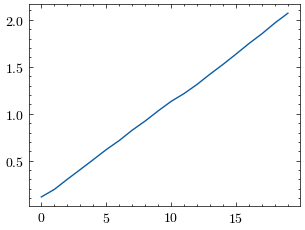

In [336]:
Q = params['env_params']['Q']           #total flow
split = params['env_params']['split']   # daily choices (opt-out, travel via env1, travel via env2)
choices =list(range(split))             # [0,1,2]

#dataframe drivers and results
df = pd.DataFrame(index = range(Q)) 
df['I'] = np.random.normal(0, 10e-9, size=len(df)) #start with infidesimal noise for I

def day(df, d, params):
    #singe day
    
    df['choice'] = np.random.choice(choices, size=len(df)) #make random choices
    df['t'] = 0
    
    #to do check if newcomers equalize as well
    if d < params['env_params']['fresh_after']:
        df['choice'] = df.apply(lambda x: x['choice'] if x.name>params['env_params']['fresh_share'] else 0, axis = 1)

    # for two environments
    dfs = list()
    for i, env in enumerate(envs):
        k = len(env.routes)
        
        df_env = df.loc[df.choice == i+1]
        df_env['I_rank']=df_env.I.rank(ascending=True).astype(int)    #agents priority
        Q_env = df.choice.value_counts()[i+1]           #flow via env
        q_env = params['env_params']['congestion']*Q_env/(Q/split)                     # normalized for BPRs
        X, _ = findUE(q_env, env.routes)  # solve UE
        tUE = env.routes[0](X[0])                       # UE time
        X, hat_T = findSO(q_env, env.routes) # SO flows and mean travel time
        tSO = [env.routes[_](X[_]) for _ in range(k)] # calc SO travel times on routes
        PoA = tUE/hat_T
        # calc realization of travel time (normal for imperfect prediction, 1e-5 for disruptions)
        p_disruption = params['env_params']['p_disruption']
        real_tSO = tSO*np.random.normal(1,params['env_params']['noise'],size = k)*np.random.choice([1, 10], p=[1-p_disruption, p_disruption], size = k)
        
        
        Is = [(real_tSO[_]-hat_T)/hat_T for _ in range(k)] # calc inequity components

        route_ranks = list(pd.Series(tSO).rank(ascending=False).values-1)
        
        
        #route_ranks = list(np.array(tSO*(-1)).argsort().argsort())

        
        splits = np.ceil(np.cumsum(X*Q_env))                              #cumulated agents capacity per route (bins)
        splits[-1]=np.inf


        
        
        df_env['route_rank'] = df_env.apply(lambda x: np.digitize(x.I_rank, splits, right = False), axis =1) # assign drivers to route ranks
        df_env['route'] = df_env.apply(lambda x: route_ranks.index(x["route_rank"]), axis =1) # assign drivers to routes
        df_env['i'] = df_env.apply(lambda x: Is[int(x["route"])], axis = 1)                                 # calc agents inequity components
        


        # cumulate Inequity
        df_env['I'] = df_env['I']+df_env['i']
        dfs.append(df_env)
        
        print(
            f"[ENV {i+1}] "
            f"routes={k}, "
            f"Q_env={Q_env:.0f}, "
            f"Is={np.mean(Is):.2f}, "
            f"q_env={q_env:.3f}, "
            f"tUE={tUE:.3f}, "
            f"tSO={tSO}, "
            f"mean_SO_time={np.mean(tSO):.3f}, "
            f"mean_inequity={df_env['i'].mean():.3f}"
            )
            
    dfs.append(df.loc[df.choice == 0])
    df = pd.concat(dfs).sort_index()
    return df

l = list()
for d in range(20):  
    df = day(df,d, params)
    l.append(df.I.mean())
plt.plot(l)

